# MNIST

First we check that conic activation function slightly outperforms ReLU on mnist classification task.

In [28]:
import jax
import jax.numpy as jnp
import numpy as np
import flax
import flax.linen as nn
import optax
import tensorflow_datasets as tfds
from flax.training.train_state import TrainState
from flax.training.common_utils import shard
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
sys.path.append('.')
from tqdm.auto import tqdm
import time
from maxdiffusion.models.act_flax import rcolu, colu
import functools
from jax_smi import initialise_tracking
initialise_tracking()

def cross_entropy_loss(logits, labels):
    one_hot_labels = jax.nn.one_hot(labels, num_classes=10)
    return optax.softmax_cross_entropy(logits, one_hot_labels).mean()

def accuracy(logits, labels):
    predictions = jnp.argmax(logits, axis=-1)
    return jnp.mean(predictions == labels)

@jax.pmap
def train_step(state, batch):
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, batch['image'])
        loss = cross_entropy_loss(logits, batch['label'])
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    acc = accuracy(logits, batch['label'])
    return state, loss, acc

@jax.pmap
def eval_step(state, batch):
    logits = state.apply_fn({'params': state.params}, batch['image'])
    loss = cross_entropy_loss(logits, batch['label'])
    acc = accuracy(logits, batch['label'])
    return loss, acc

def prepare_data(data_name):
    ds_builder = tfds.builder(data_name)
    ds_builder.download_and_prepare()
    train_ds = tfds.as_numpy(tfds.load(data_name, split='train', batch_size=128, shuffle_files=True))
    test_ds = tfds.as_numpy(tfds.load(data_name, split='test', batch_size=128))
    return train_ds, test_ds

def create_train_state(model, rng, learning_rate, weight_decay=.01):
    params = model.init(rng, jnp.ones([1, 28, 28, 1]))['params']
    
    def weight_decay_mask(params):
        return {k: 'bias' not in k and 'scale' not in k for k in params.keys()}

    tx = optax.adamw(learning_rate=learning_rate, weight_decay=weight_decay, mask=weight_decay_mask(params))
    return TrainState.create(apply_fn=model.apply, params=params, tx=tx)

def train_and_evaluate(model, num_epochs, learning_rate):
    rng = jax.random.PRNGKey(int(time.time()))
    # rng = jax.random.PRNGKey(0)
    rngs = {'params': rng}
    train_ds, test_ds = prepare_data('mnist')
    state = create_train_state(model, rngs, learning_rate)
     
    # Replicate state across devices
    state = jax.device_put_replicated(state, jax.local_devices())

    # bar = tqdm(range(num_epochs),leave=0)
    bar = range(num_epochs)
    # pbar = tqdm(range(len(train_ds)),leave=1)
    best_test_acc = list()
    for _ in bar:
        # pbar.reset()
        # Training loop
        for batch in train_ds:
            # pbar.update(1)
            batch = shard(batch)
            state, train_loss, train_acc = train_step(state, batch)
            train_loss, train_acc = jax.device_get(flax.jax_utils.unreplicate((train_loss, train_acc)))
            # pbar.set_postfix(dict(train_loss=train_loss,train_acc=train_acc))

        # Evaluation loop
        test_loss, test_acc = 0, 0
        for batch in test_ds:
            batch = shard(batch)
            loss, acc = eval_step(state, batch)
            test_loss += loss.mean()
            test_acc += acc.mean()

        test_loss /= len(test_ds)
        test_acc /= len(test_ds)
        best_test_acc.append(test_acc.item())

        # bar.set_postfix({'Test Loss':test_loss,'Test Acc':test_acc})
        
    # pbar.close()
    # bar.close()
    best_test_acc = max(best_test_acc)
    print('Test Loss',test_loss,'Test Acc',test_acc,'Best Test Acc',best_test_acc)
    return best_test_acc

# validate different activation functions
def validate_activation(fn,C=512):
    class MNISTModel(nn.Module):
        @nn.compact
        def __call__(self, x):
            x = x.reshape(-1, 28 * 28)  # Flatten the input
            x = nn.Dense(features=C)(x)
            x = fn(x)
            x = nn.Dense(features=10)(x)
            return x
    
    model = MNISTModel()
    best_test_acc = []
    for _ in range(10):
        best_test_acc.append(train_and_evaluate(model, num_epochs=10, learning_rate=1e-3))
    
    print(f'{np.mean(best_test_acc)} ± {np.std(best_test_acc)}')


Exception in thread Thread-118 (inner):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/evergreen/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.10/threading.py", line 953, in run


    self._target(*self._args, **self._kwargs)
  File "/home/evergreen/.local/lib/python3.10/site-packages/jax_smi/initialise_tracking.py", line 10, in inner
    posix.rename(f'{dir_prefix}/memory.prof.new', f'{dir_prefix}/memory.prof')  # atomic
FileNotFoundError: [Errno 2] No such file or directory: '/dev/shm/memory.prof.new' -> '/dev/shm/memory.prof'


In [25]:
fn = functools.partial(rcolu,num_groups=None,dim=4)
validate_activation(fn,C=512)

Test Loss 8.6116495 Test Acc 0.94699365 Best Test Acc 0.9469936490058899
Test Loss 9.428128 Test Acc 0.9437302 Best Test Acc 0.9437301754951477
Test Loss 9.258818 Test Acc 0.9463014 Best Test Acc 0.9473891854286194
Test Loss 8.306987 Test Acc 0.94897145 Best Test Acc 0.9489714503288269
Test Loss 9.527463 Test Acc 0.9451147 Best Test Acc 0.9485759139060974
Test Loss 9.53101 Test Acc 0.9445213 Best Test Acc 0.9462024569511414
Test Loss 9.417345 Test Acc 0.9427413 Best Test Acc 0.9446201920509338
Test Loss 8.379103 Test Acc 0.9509493 Best Test Acc 0.9509493112564087
Test Loss 8.7150955 Test Acc 0.94887257 Best Test Acc 0.9488725662231445
Test Loss 8.919978 Test Acc 0.94699365 Best Test Acc 0.9471914172172546
0.9473496317863465 ± 0.00203545376032162


In [3]:
fn = nn.relu
validate_activation(fn)

Test Loss 0.9517396 Test Acc 0.93888444 Best Test Acc 0.938884437084198
Test Loss 0.87694514 Test Acc 0.93789554 Best Test Acc 0.9420490264892578
Test Loss 0.9394104 Test Acc 0.9430379 Best Test Acc 0.9430379271507263
Test Loss 0.7890036 Test Acc 0.94165343 Best Test Acc 0.9416534304618835
Test Loss 0.8576852 Test Acc 0.9375988 Best Test Acc 0.9375988245010376
Test Loss 1.0372221 Test Acc 0.9381922 Best Test Acc 0.9381921887397766
Test Loss 0.92235553 Test Acc 0.9406645 Best Test Acc 0.940664529800415
Test Loss 1.0847064 Test Acc 0.93601656 Best Test Acc 0.9424445629119873
Test Loss 0.8478746 Test Acc 0.9353243 Best Test Acc 0.938291072845459
Test Loss 0.98507917 Test Acc 0.93928003 Best Test Acc 0.9392800331115723


{'mean': 0.9402096033096313, 'std': 0.001893583526538625}

In [ ]:
fn = functools.partial(rcolu,num_groups=None,dim=3)
validate_activation(fn,C=513)

Test Loss 10.279629 Test Acc 0.9417523 Best Test Acc 0.9417523145675659
Test Loss 10.1396 Test Acc 0.9454113 Best Test Acc 0.9489714503288269
Test Loss 9.81035 Test Acc 0.94531244 Best Test Acc 0.9453124403953552
Test Loss 9.391808 Test Acc 0.9497626 Best Test Acc 0.9497625827789307
Test Loss 8.951644 Test Acc 0.9481803 Best Test Acc 0.9481803178787231
Test Loss 9.499583 Test Acc 0.9430379 Best Test Acc 0.9444224238395691
Test Loss 11.328159 Test Acc 0.9381922 Best Test Acc 0.9462024569511414
Test Loss 9.084599 Test Acc 0.94887257 Best Test Acc 0.9488725662231445
Test Loss 9.224252 Test Acc 0.9491693 Best Test Acc 0.9491692781448364
Test Loss 10.45912 Test Acc 0.9464003 Best Test Acc 0.9464002847671509
0.9469046115875244 ± 0.0024301976194708026


#### Result:

|Activation    | Test Accuracy                             |
|--------------|-------------------------------------------|
|relu          | 0.9399129211902618 ± 0.0018681033013814648|
|rcolu (dim=4) | 0.9467661738395691 ± 0.0020805275338002405|
|colu (4,hard) | 0.9249010622501374 ± 0.0018385487250506005|
|colu (3,soft) | 0.9244066059589386 ± 0.004504809645835173 |
|colu (3_sh_sf)| 0.9441455185413361 ± 0.0026118897350840696|

In [2]:
fn = functools.partial(colu,num_groups=None,dim=4,variant="hard")
validate_activation(fn)

Test Loss 5.0856586 Test Acc 0.9242484 Best Test Acc 0.9245450496673584
Test Loss 6.6347713 Test Acc 0.91040343 Best Test Acc 0.9274129271507263
Test Loss 5.4483886 Test Acc 0.92365503 Best Test Acc 0.9236550331115723
Test Loss 4.9724417 Test Acc 0.92365503 Best Test Acc 0.9236550331115723
Test Loss 5.043076 Test Acc 0.9242484 Best Test Acc 0.9260284304618835
Test Loss 6.1648397 Test Acc 0.91772145 Best Test Acc 0.9255339503288269
Test Loss 5.5091915 Test Acc 0.92078716 Best Test Acc 0.9262261986732483
Test Loss 5.141494 Test Acc 0.9257318 Best Test Acc 0.9257317781448364
Test Loss 5.3612003 Test Acc 0.9257318 Best Test Acc 0.9257317781448364
Test Loss 5.1129265 Test Acc 0.919996 Best Test Acc 0.9204904437065125


{'mean': 0.9249010622501374, 'std': 0.0018385487250506005}

In [34]:
fn = functools.partial(colu,num_groups=None,dim=3,variant="soft",share_axis=False)
validate_activation(fn,C=513)

Test Loss 5.465614 Test Acc 0.92078716 Best Test Acc 0.9287974238395691
Test Loss 5.9785495 Test Acc 0.9242484 Best Test Acc 0.9242483973503113
Test Loss 6.447693 Test Acc 0.9159414 Best Test Acc 0.9205893278121948
Test Loss 5.562606 Test Acc 0.9274129 Best Test Acc 0.9274129271507263
Test Loss 5.765641 Test Acc 0.9189082 Best Test Acc 0.9196004271507263
Test Loss 5.5702 Test Acc 0.92187494 Best Test Acc 0.9223694205284119
Test Loss 6.435885 Test Acc 0.91811705 Best Test Acc 0.9181170463562012
Test Loss 5.9301157 Test Acc 0.9209849 Best Test Acc 0.9228639006614685
Test Loss 4.793993 Test Acc 0.93374205 Best Test Acc 0.9337420463562012
Test Loss 4.9463162 Test Acc 0.92632514 Best Test Acc 0.9263251423835754
0.9244066059589386 ± 0.004504809645835173


In [26]:
fn = functools.partial(colu,num_groups=None,dim=3,variant="soft",share_axis=True)
validate_activation(fn,C=513)

Test Loss 0.50016326 Test Acc 0.94551027 Best Test Acc 0.9455102682113647
Test Loss 0.52199095 Test Acc 0.9389833 Best Test Acc 0.9389833211898804
Test Loss 0.7850288 Test Acc 0.9302808 Best Test Acc 0.9467958211898804
Test Loss 0.6030285 Test Acc 0.9382911 Best Test Acc 0.9403678178787231
Test Loss 0.52857697 Test Acc 0.9408623 Best Test Acc 0.9424445629119873
Test Loss 0.5734586 Test Acc 0.94392794 Best Test Acc 0.9439279437065125
Test Loss 0.49458688 Test Acc 0.94432354 Best Test Acc 0.9443235397338867
Test Loss 0.6522249 Test Acc 0.93482983 Best Test Acc 0.9469936490058899
Test Loss 0.50361294 Test Acc 0.9459058 Best Test Acc 0.9459058046340942
Test Loss 0.48903513 Test Acc 0.94620246 Best Test Acc 0.9462024569511414
0.9441455185413361 ± 0.0026118897350840696


#### axis=$\mathbf 1$ works better than axis=$e_1$ 

# CIFAR10

In [18]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import tensorflow_datasets as tfds
from flax.training.train_state import TrainState
import numpy as np
import time
import flax
from flax.training.common_utils import shard
from maxdiffusion.models.act_flax import rcolu, colu

# Data loading and preprocessing
def load_data():
    ds_builder = tfds.builder('cifar10')
    ds_builder.download_and_prepare()
    train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
    test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
    
    def preprocess(data):
        images = jax.device_put(data['image'].astype(np.float32) / 255.0)
        labels = jax.device_put(data['label'])
        return images, labels
    
    train_images, train_labels = preprocess(train_ds)
    test_images, test_labels = preprocess(test_ds)
    return train_images, train_labels, test_images, test_labels

# Loss function

# Update function
@jax.pmap
def update_model(state, images, labels):
    def compute_loss(params):
        logits = state.apply_fn({'params': params}, images)
        loss = optax.softmax_cross_entropy(logits=logits, labels=jax.nn.one_hot(labels, 10)).mean()
        return loss
    grads = jax.grad(compute_loss)(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state

# Accuracy function
@jax.pmap
def compute_accuracy(state, images, labels):
    logits = state.apply_fn({'params': state.params}, images)
    predicted_labels = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(predicted_labels == labels)
    return accuracy

# Training function
def train_model(model,train_images, train_labels, test_images, test_labels, num_epochs=10, batch_size=64,lr=1e-3):
    rng = jax.random.PRNGKey(int(time.time()))
    input_shape = train_images.shape[1:]
    rng, init_rng = jax.random.split(rng)
    params = model.init(init_rng, jnp.ones([1] + list(input_shape)))['params']
    state = TrainState.create(apply_fn=model.apply, params=params, tx=optax.adam(lr))
    state = flax.jax_utils.replicate(state)
    
    num_train_steps = len(train_images) // batch_size
    for epoch in range(num_epochs):
        for i in range(num_train_steps):
            batch_images = train_images[i * batch_size:(i + 1) * batch_size]
            batch_labels = train_labels[i * batch_size:(i + 1) * batch_size]
            batch_images,batch_labels = shard((batch_images,batch_labels))
            state = update_model(state, batch_images, batch_labels)
        
        num_samples = 10240 # just do a one-pass test roughly
        batch_images,batch_labels = shard((train_images[:num_samples], train_labels[:num_samples]))
        train_acc = compute_accuracy(state, batch_images,batch_labels)
        batch_images,batch_labels = shard((test_images[:num_samples], test_labels[:num_samples]))
        test_acc = compute_accuracy(state, batch_images,batch_labels)
        train_acc, test_acc = flax.jax_utils.unreplicate((train_acc, test_acc))
        print(f'Epoch {epoch + 1}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')
    
    return state

def validate_activation_cifar10(fn,C=512):
    class CNN(nn.Module):
        @nn.compact
        def __call__(self, x):
            x = nn.Conv(features=C, kernel_size=(3, 3))(x)
            x = fn(x)
            x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
            
            x = nn.Conv(features=C, kernel_size=(3, 3))(x)
            x = fn(x)
            x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
            
            x = nn.Conv(features=C, kernel_size=(3, 3))(x)
            x = fn(x)
            x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
            
            x = x.reshape((x.shape[0], -1))  # flatten
            x = nn.Dense(features=C)(x)
            x = fn(x)
            x = nn.Dense(features=10)(x)
            return x

    model = CNN()
    train_images, train_labels, test_images, test_labels = load_data()
    state = train_model(model,train_images, train_labels, test_images, test_labels, num_epochs=10)
    return state


#### Result:

|Activation     | Test Accuracy                             |
|---------------|-------------------------------------------|
|relu           | 0.5369|
|colu (group=1) | 0.4456|
|colu (dim=4,sh)| 0.5471|
|colu (dim=4)   | 0.6084 |
|colu (3_sh_sf) | 0.6088|
|rcolu (group=1)| 0.1692|
|rcolu (dim=4)  | 0.1092(Does not converge) |
|rcolu (dim=3)  | 0.6076 |
|rcolu (dim=2)  | 0.5580 |

In [17]:
fn = nn.relu
C = 512
validate_activation_cifar10(fn,C);

Epoch 1, Train Accuracy: 0.4766, Test Accuracy: 0.4792
Epoch 2, Train Accuracy: 0.5340, Test Accuracy: 0.5268
Epoch 3, Train Accuracy: 0.5602, Test Accuracy: 0.5388
Epoch 4, Train Accuracy: 0.5801, Test Accuracy: 0.5540
Epoch 5, Train Accuracy: 0.6148, Test Accuracy: 0.5748
Epoch 6, Train Accuracy: 0.6113, Test Accuracy: 0.5672
Epoch 7, Train Accuracy: 0.6156, Test Accuracy: 0.5660
Epoch 8, Train Accuracy: 0.6379, Test Accuracy: 0.5752
Epoch 9, Train Accuracy: 0.6137, Test Accuracy: 0.5400
Epoch 10, Train Accuracy: 0.6313, Test Accuracy: 0.5660


In [7]:

import functools
import gc
gc.collect()

# Define the CNN model
fn = functools.partial(colu,num_groups=1,dim=None)
C = 512
validate_activation_cifar10(fn,C);

Epoch 1, Train Accuracy: 0.3423, Test Accuracy: 0.3418
Epoch 2, Train Accuracy: 0.4331, Test Accuracy: 0.4382
Epoch 3, Train Accuracy: 0.4485, Test Accuracy: 0.4517
Epoch 4, Train Accuracy: 0.4626, Test Accuracy: 0.4592
Epoch 5, Train Accuracy: 0.4844, Test Accuracy: 0.4419
Epoch 6, Train Accuracy: 0.4287, Test Accuracy: 0.3948
Epoch 7, Train Accuracy: 0.4700, Test Accuracy: 0.4412
Epoch 8, Train Accuracy: 0.4719, Test Accuracy: 0.4456
Epoch 9, Train Accuracy: 0.4897, Test Accuracy: 0.4607
Epoch 10, Train Accuracy: 0.4622, Test Accuracy: 0.4456


In [19]:

fn = functools.partial(colu,num_groups=None,dim=4,share_axis=False)
C = 512
validate_activation_cifar10(fn,C);

Epoch 1, Train Accuracy: 0.5164, Test Accuracy: 0.5408
Epoch 2, Train Accuracy: 0.5887, Test Accuracy: 0.6052
Epoch 3, Train Accuracy: 0.6086, Test Accuracy: 0.6032
Epoch 4, Train Accuracy: 0.6422, Test Accuracy: 0.5972
Epoch 5, Train Accuracy: 0.6785, Test Accuracy: 0.6212
Epoch 6, Train Accuracy: 0.6594, Test Accuracy: 0.6260
Epoch 7, Train Accuracy: 0.6773, Test Accuracy: 0.6124
Epoch 8, Train Accuracy: 0.6383, Test Accuracy: 0.6048
Epoch 9, Train Accuracy: 0.6918, Test Accuracy: 0.6268
Epoch 10, Train Accuracy: 0.6816, Test Accuracy: 0.6084


In [2]:

fn = functools.partial(colu,num_groups=None,dim=4,share_axis=True)
C = 512
validate_activation_cifar10(fn,C);

2024-07-15 09:56:43.711137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 09:56:43.732838: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 09:56:43.739502: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-15 09:56:44.805837: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1, Train Accuracy: 0.4690, Test Accuracy: 0.4802
Epoch 2, Train Accuracy: 0.5593, Test Accuracy: 0.5452
Epoch 3, Train Accuracy: 0.5757, Test Accuracy: 0.5564
Epoch 4, Train Accuracy: 0.5889, Test Accuracy: 0.5498
Epoch 5, Train Accuracy: 0.6023, Test Accuracy: 0.5527
Epoch 6, Train Accuracy: 0.6091, Test Accuracy: 0.5527
Epoch 7, Train Accuracy: 0.6230, Test Accuracy: 0.5549
Epoch 8, Train Accuracy: 0.6350, Test Accuracy: 0.5752
Epoch 9, Train Accuracy: 0.6335, Test Accuracy: 0.5718
Epoch 10, Train Accuracy: 0.6130, Test Accuracy: 0.5471


In [ ]:

fn = functools.partial(rcolu,num_groups=1,dim=None)
C = 512
validate_activation_cifar10(fn,C);

In [23]:
fn = functools.partial(rcolu,num_groups=None,dim=3)
C = 510
validate_activation_cifar10(fn,C);

Epoch 1, Train Accuracy: 0.5016, Test Accuracy: 0.5204
Epoch 2, Train Accuracy: 0.5520, Test Accuracy: 0.5444
Epoch 3, Train Accuracy: 0.5457, Test Accuracy: 0.5508
Epoch 4, Train Accuracy: 0.5074, Test Accuracy: 0.5100
Epoch 5, Train Accuracy: 0.4805, Test Accuracy: 0.4900
Epoch 6, Train Accuracy: 0.6387, Test Accuracy: 0.6124
Epoch 7, Train Accuracy: 0.6504, Test Accuracy: 0.6120
Epoch 8, Train Accuracy: 0.6871, Test Accuracy: 0.6348
Epoch 9, Train Accuracy: 0.6777, Test Accuracy: 0.6240
Epoch 10, Train Accuracy: 0.6570, Test Accuracy: 0.6076


In [24]:
fn = functools.partial(rcolu,num_groups=None,dim=2)
C = 512
validate_activation_cifar10(fn,C);

Epoch 1, Train Accuracy: 0.5086, Test Accuracy: 0.5204
Epoch 2, Train Accuracy: 0.5379, Test Accuracy: 0.5656
Epoch 3, Train Accuracy: 0.5543, Test Accuracy: 0.5464
Epoch 4, Train Accuracy: 0.3480, Test Accuracy: 0.3684
Epoch 5, Train Accuracy: 0.6262, Test Accuracy: 0.6160
Epoch 6, Train Accuracy: 0.6578, Test Accuracy: 0.6396
Epoch 7, Train Accuracy: 0.6813, Test Accuracy: 0.6528
Epoch 8, Train Accuracy: 0.6707, Test Accuracy: 0.6284
Epoch 9, Train Accuracy: 0.6223, Test Accuracy: 0.6036
Epoch 10, Train Accuracy: 0.5828, Test Accuracy: 0.5580


In [ ]:
fn = functools.partial(colu,num_groups=None,dim=3,variant="soft",share_axis=True)
C = 511
validate_activation_cifar10(fn,C);

# Rotate Tangent Space of Color Images

We perform a hue rotation on CIFAR10.

2024-07-15 21:43:51.989749: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


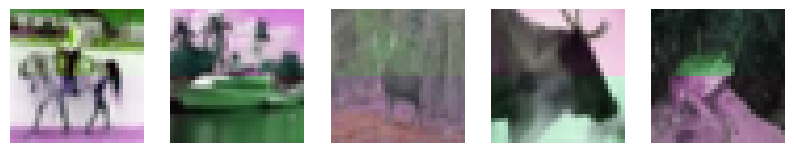

2024-07-15 21:43:52.186151: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(32, 32, 32, 3) (32,)


In [25]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
# Load dataset
dataset = tfds.load('cifar10', split='train')

# Define hue rotation function
def rotate_hue(example, delta):
    example['image'] = tf.cast(example['image'], tf.float32)
    example['image'] = (example['image'] + 0.5) / 255.0 #* 2.0 - 1.0  # Normalize to [-1, 1]
    example['image'] = tf.clip_by_value(example['image'], 0.0, 1.0)
    rotate_fn = lambda x, d: tf.image.adjust_hue(x, d)
    x,y = example['image'][:16], example['image'][16:]
    example['image'] = tf.concat([rotate_fn(x,delta), rotate_fn(y,-delta)], axis=0)
    return example

# Apply hue rotation
delta = .25  # Adjust this value as needed
dataset = dataset.map(lambda example: rotate_hue(example, delta), 
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Optional: Visualize the results
def show_examples(dataset, num_examples):
    plt.figure(figsize=(10, 10))
    for i, example in enumerate(dataset.take(num_examples)):
        plt.subplot(1, num_examples, i+1)
        plt.imshow(example['image'])
        plt.axis('off')
    plt.show()

show_examples(dataset, 5)

# Prepare dataset for training
batch_size = 32
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
for example in dataset:
    print(example['image'].shape, example['label'].shape)
    break



In [43]:
# redefine dataset

def rotate_hue(example):
    delta = tf.random.uniform([], minval=-1, maxval=1)
    example['image'] = tf.cast(example['image'], tf.float32)
    example['image'] = (example['image'] + 0.5) / 255.0 #* 2.0 - 1.0  # Normalize to [-1, 1]
    example['image'] = tf.clip_by_value(example['image'], 0.0, 1.0)
    rotate_fn = lambda x, d: tf.image.adjust_hue(x, d)
    example['image'] = rotate_fn(example['image'],delta)
    return example


def load_data():
    ds_builder = tfds.builder('cifar10')
    ds_builder.download_and_prepare()
    
    # Load the dataset
    train_ds = ds_builder.as_dataset(split='train')
    test_ds = ds_builder.as_dataset(split='test')
    
    # Apply the map function before converting to NumPy
    train_ds = train_ds.map(rotate_hue)
    test_ds = test_ds.map(rotate_hue)
    
    # Get the number of examples in the dataset
    num_train_examples = ds_builder.info.splits['train'].num_examples
    num_test_examples = ds_builder.info.splits['test'].num_examples

    # Batch the dataset to get all examples in a single batch
    train_ds = train_ds.batch(num_train_examples)
    test_ds = test_ds.batch(num_test_examples)

    # Convert the datasets to NumPy format and load the entire batch
    train_batch = tfds.as_numpy(train_ds)
    test_batch = tfds.as_numpy(test_ds)

    # Extract images and labels from the dictionaries
    train_images, train_labels = next(iter(train_batch))['image'], next(iter(train_batch))['label']
    test_images, test_labels = next(iter(test_batch))['image'], next(iter(test_batch))['label']

    return train_images, train_labels, test_images, test_labels


train_images, train_labels, test_images, test_labels = load_data()
train_images.shape

(50000, 32, 32, 3)

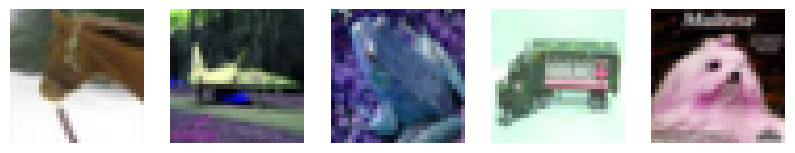

In [58]:
i=0
plt.figure(figsize=(10,2))
for image in test_images:
    plt.subplot(1,5,i+1)
    plt.imshow(image)
    plt.axis('off')
    i+=1
    if i>=5:
        break

In [44]:
fn = functools.partial(colu,num_groups=None,dim=3,variant="soft",share_axis=True)
C = 511
validate_activation_cifar10(fn,C);

Epoch 1, Train Accuracy: 0.4418, Test Accuracy: 0.4380
Epoch 2, Train Accuracy: 0.4938, Test Accuracy: 0.4948
Epoch 3, Train Accuracy: 0.5641, Test Accuracy: 0.5472
Epoch 4, Train Accuracy: 0.5820, Test Accuracy: 0.5640
Epoch 5, Train Accuracy: 0.5918, Test Accuracy: 0.5712
Epoch 6, Train Accuracy: 0.5754, Test Accuracy: 0.5308
Epoch 7, Train Accuracy: 0.6320, Test Accuracy: 0.5668
Epoch 8, Train Accuracy: 0.6281, Test Accuracy: 0.5564
Epoch 9, Train Accuracy: 0.6238, Test Accuracy: 0.5624
Epoch 10, Train Accuracy: 0.6047, Test Accuracy: 0.5444


In [45]:
fn = nn.relu
C = 511
validate_activation_cifar10(fn,C);

Epoch 1, Train Accuracy: 0.4148, Test Accuracy: 0.4260
Epoch 2, Train Accuracy: 0.4707, Test Accuracy: 0.4664
Epoch 3, Train Accuracy: 0.5059, Test Accuracy: 0.4868
Epoch 4, Train Accuracy: 0.5160, Test Accuracy: 0.5012
Epoch 5, Train Accuracy: 0.5402, Test Accuracy: 0.4912
Epoch 6, Train Accuracy: 0.5656, Test Accuracy: 0.5160
Epoch 7, Train Accuracy: 0.6016, Test Accuracy: 0.5284
Epoch 8, Train Accuracy: 0.5898, Test Accuracy: 0.5188
Epoch 9, Train Accuracy: 0.5918, Test Accuracy: 0.5216
Epoch 10, Train Accuracy: 0.5855, Test Accuracy: 0.5196


# Dimensionality Reduction

2024-07-12 15:25:16.398904: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 15:25:16.398965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 15:25:16.400004: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-12 15:25:16.407587: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-12 15:25:17.516433: W tensorflow/compiler/tf2

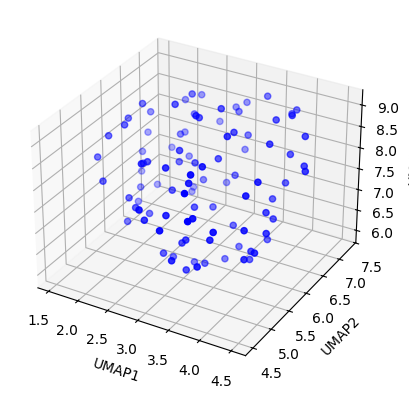

In [ ]:
import numpy as np
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Step 1: Generate example high-dimensional data
data = np.random.rand(100, 50)

# Step 2: Create a UMAP object for 3D embedding
umap_3d = umap.UMAP(n_components=3, random_state=42)

# Step 3: Fit and transform the data
embedding_3d = umap_3d.fit_transform(data)

# Step 4: Visualize the 3D embedding
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedding_3d[:, 0], embedding_3d[:, 1], embedding_3d[:, 2], c='blue', marker='o')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
plt.show()
